# 2. Quickstart

This section provides a lightning-fast introduction to the IntPrim API and how it can be used to model interactions. The full code for this section can be found under `examples/minimal.py`. Before proceeding, please ensure that IntPrim has been downloaded and installed as a Python package, per the instructions in `README.md`.

### Fitting a model to demonstrations

First, we will begin by importing the library and creating some sample handwriting data from a utility function. This is simple 2D data with two correlated degrees of freedom, and it is reasonable to assume that this data could be produced by two interacting agents; one agent draws one degree of freedom and the second agent draws the other.

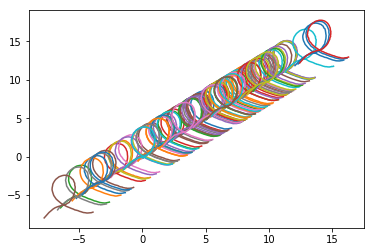

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Import the library.
import intprim

# Set a seed for reproducibility
np.random.seed(213413414)

# Define some parameters used when generating synthetic data.
num_train_trajectories = 100
train_translation_mean = 0.0
train_translation_std = 5.0
train_noise_std = 0.01
train_length_mean = 95
train_length_std = 30

# Generate some synthetic handwriting trajectories.
training_trajectories = intprim.examples.create_2d_handwriting_data(
    num_train_trajectories,
    train_translation_mean,
    train_translation_std,
    train_noise_std,
    train_length_mean,
    train_length_std)

# Plot the results.
plt.figure()
for trajectory in training_trajectories:
    plt.plot(trajectory[0], trajectory[1])
plt.show()

The above code generates 100 synthetic handwriting demonstrations which have minimal noise, however, they vary significantly in sequence length (standard deviation of 30 time steps with a mean of 95).
Each demonstration has been translated in both the x- and y-axis by some value; it is important that they are translated by correlated values because we need to create a correlation between the axes -- we use the same value here for the sake of simplicity.

Next, we will define a basis space and train the model.

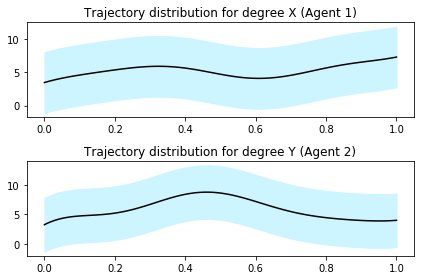

In [2]:
# Define the data axis names.
dof_names = np.array(["X (Agent 1)", "Y (Agent 2)"])

# Decompose the handwriting trajectories to a basis space with 8 uniformly distributed Gaussian functions and a variance of 0.1.
basis_model = intprim.basis.GaussianModel(8, 0.1, dof_names)

# Initialize a BIP instance.
primitive = intprim.BayesianInteractionPrimitive(basis_model)

# Train the model.
for trajectory in training_trajectories:
    primitive.add_demonstration(trajectory)

# Plot the distribution of the trained model.
mean, upper_bound, lower_bound = primitive.get_probability_distribution()
intprim.util.visualization.plot_distribution(dof_names, mean, upper_bound, lower_bound)

The figure above shows the trained distribution.
The black line indicates the mean of each degree of freedom and the the shaded blue region represents one standard deviation.
Fundamentally, this distribution reprents our "uncertainty" about where we think a successful interaction lies in the state space consisting of all degrees of freedom.
Here, the uncertainty is constant at each point in time because we applied a translation to each individual data point; there is no single point that all demonstrations converge to, for example.
However, the magnitude of the uncertainty corresponds to the variance in the provided demonstrations.
In the figure above, the shaded blue region roughly has a height of 5.0 units, which happens to be the same value set in train_translation_std.
This can be tested by changing the train_translation_std and re-running the above code.
 
### Testing a model against new interactions

When we refer to "testing" our model, what we mean is that we will observe one or more degrees of freedom and infer all degrees of freedom, including those that we did not observe.
Then we can compare the inferred values to the ground truth to see how well our model performed.
In our case, we will only observe the y-axis values (the x-axis will be zeroed out in the testing trajectory) and we will compute both the error in the inferred degrees of freedom as well as the estimated phase.

In order to test our model we must provide three things:
1. The observation/measurement noise
2. A filter to perform spatiotemporal inference with
3. Testing trajectories

First, we define the observation noise.

In [3]:
# Set an observation noise for the demonstrations.
observation_noise = np.diag([10000.0, train_noise_std ** 2])

Normally, this noise is computed from the data directly (see *Computing observation noise* in Section 3), however, we explicitly define it here so that we can discuss it.
The first value has been set to some arbitrarily high amount to represent a large degree of uncertainty in the observed values.
Technically, since we don't observe these values at all we would want this to be infinite, but infinite (and even very large values) tend to cause numerical problems in calculations and so we keep things reasonable.
Furthermore, since this is synthetic data we know exactly what the true noise value so we can go ahead and plug that in directly.
The only error that is unaccounted for now is the regression error in the basis approximation, however, for this contrived example that error will be trivial so we can ignore it for now.

Next, we need to create a spatiotemporal filter.

In [4]:
# Compute the phase mean and phase velocities from the demonstrations.
phase_velocity_mean, phase_velocity_var = intprim.examples.get_phase_stats(training_trajectories)

# Define a filter to use. Here we use an ensemble Kalman filter
filter = intprim.filter.spatiotemporal.EnsembleKalmanFilter(
    basis_model = basis_model,
    initial_phase_mean = [0.0, phase_velocity_mean],
    initial_phase_var = [1e-4, phase_velocity_var],
    proc_var = 1e-8,
    initial_ensemble = primitive.basis_weights)

The specifics behind what this filter does is described in detail in Section X, however, the short answer is that it performs spatiotemporal inference.
In other words, as we provide observations the filter will estimate both how far the interaction has progressed (phase) as well as the estimated state of the current interaction, including the future trajectories for all degrees of freedom.
In this example we're using an ensemble Kalman filter, which is a Monte Carlo approximation of a standard Kalman filter.

Lastly, we will create a new trajectory to test against.
We choose a rather extreme example and force both the translation and the sequence length to be at the very edge of our training distribution.
To emphasize that we are only paying attention to the y-axis values, we also zero out the x-axis.

In [5]:
num_test_trajectories = 1
test_translation_mean = 5.0
test_translation_std = 1e-5
test_noise_std = 0.01
test_length_mean = 45
test_length_std = 1e-5

# Create test trajectories.
test_trajectories = intprim.examples.create_2d_handwriting_data(num_test_trajectories, test_translation_mean, test_translation_std, test_noise_std, test_length_mean, test_length_std)

# Explicitly zero out the x-axis values to illustrate that they are not being used.
test_trajectory_partial = np.array(test_trajectories[0], copy = True)
test_trajectory_partial[0, :] = 0.0

And then it's just a matter of performing inference.
To demonstrate the recursive nature of the filter, we will iterate the test trajectory in chunks of 8 observations and perform inference after each one.

In [6]:
import copy

# We set a copy of the filter here so we can re-use it later. The filter maintains internal state information and should not be used more than once.
primitive.set_filter(copy.deepcopy(filter))

prev_observed_index = 0
for observed_index in range(8, test_trajectory_partial.shape[1], 8):
    inferred_trajectory, phase, mean, var = primitive.generate_probable_trajectory_recursive(test_trajectory_partial[:, prev_observed_index:observed_index], observation_noise, np.array([1]), num_samples = test_trajectory_partial.shape[1] - observed_index)
    prev_observed_index = observed_index

Each time `generate_probable_trajectory_recursive` is called, it computes the trajectory of each degree of freedom from the currently estimated point in time all the way to the end of the interaction.
The issue with the above code is that it simply performs inference, we don't have any metric for how well it performs.
To simplify matters, some code has been created which will automatically perform inference and compute errors of both the degrees of freedom as well as the inferred phase.

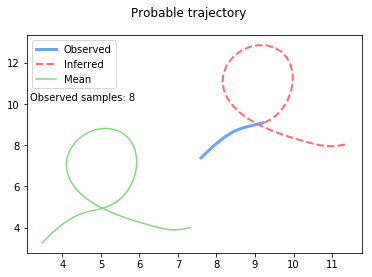

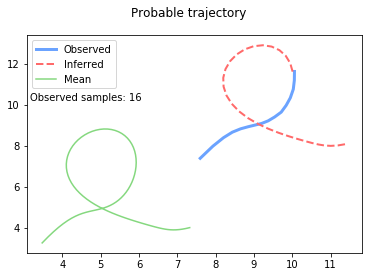

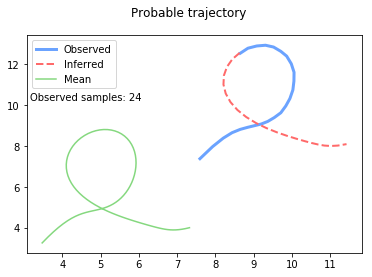

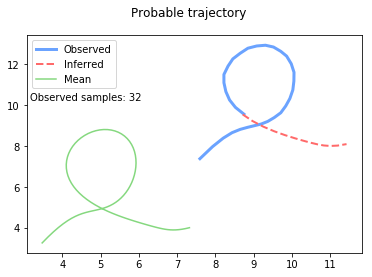

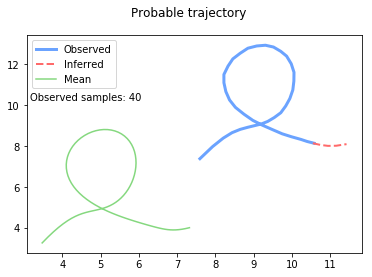

Mean DoF MSE: 0.01624953624. Phase MAE: 0.0086014280389


In [7]:
# Evaluate the trajectories.
intprim.examples.evaluate_trajectories(primitive, filter, test_trajectories, observation_noise)

The test trajectory that we used is an extreme case, we forced the translation to +5.0 with a sequence length of 45, less than half of the training sequence mean.
And yet, as indicated by both the DoF MSE and phase MAE, our inference is pretty much spot on.
The animation reinforces this notion: at each time step we incorporate the next 8 measurements (blue line) and infer the remaining trajectory (dashed red line).
Even though we are inferring the x-axis values, the results are nearly indistinguishable from the actual values.